### Янгаличин Олег 184-322

# Классификация с помощью softmax

Содержание практической работы:

- функция потерь для softmax
- аналитический градиент
- его проверка с помощью численного градиента
- подбор скорости обучения и степени регуляризации на проверочной выборке
- оптимизация функции потерь с помощью стохастического градиентного спуска
- визуализация конечных весов

Статья о [Softmax](https://www.pyimagesearch.com/2016/09/12/softmax-classifiers-explained/) [eng]
[Реализация 2 вариантов Softmax](https://ljvmiranda921.github.io/notebook/2017/02/14/softmax-classifier/) [eng]

In [17]:
# Подключим основные библиотеки
from __future__ import print_function

import math
import random
import time
from builtins import object, range

import matplotlib.pyplot as plt
import numpy as np
#from past.builtins import xrange

from random import randrange
%matplotlib inline

## Загрузка базы CIFAR-10, создание выборок и подвыборок, первичная обработка и нормализация данных

In [18]:
# # Определим функции для загрузки базы CIFAR-10

# from six.moves import cPickle as pickle
# import os
# import platform

# def load_pickle(f):
#     version = platform.python_version_tuple()
#     if version[0] == '2':
#         return  pickle.load(f)
#     elif version[0] == '3':
#         return  pickle.load(f, encoding='latin1')
#     raise ValueError("Неверная версия Python: {}".format(version))

# def load_CIFAR_batch(filename):
#     with open(filename, 'rb') as f:
#         datadict = load_pickle(f)
#         X = datadict['data']
#         Y = datadict['labels']
#         X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
#         Y = np.array(Y)
#         return X, Y

# def load_CIFAR10(ROOT):
#     xs = []
#     ys = []
#     for b in range(1,6):
#         f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
#         X, Y = load_CIFAR_batch(f)
#         xs.append(X)
#         ys.append(Y)
#     Xtr = np.concatenate(xs)
#     Ytr = np.concatenate(ys)
#     del X, Y
#     Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
#     return Xtr, Ytr, Xte, Yte

In [19]:
def procces_y_data(y):
    y_true = y
    y_ok =[]
    for i in range(len(y_true)):
        y_ok.append(y_true[i][0])
    return np.array(y_ok)

In [20]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):

#     # Путь до данных необходимо указать свой    
#     cifar10_dir = '.\\cifar10'
    
#     # Сброс переменных для избежания многократной загрузки базы в память
#     try:
#         del X_train, y_train
#         del X_test, y_test
#         print('Сброс предыдущих данных.')
#     except:
#         pass

#     X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    from keras.datasets import cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')
    y_train = procces_y_data(y_train)
    y_test = procces_y_data(y_test)
    
    
    # подвыбоки
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Первичная обработка данных: преобразования изображений в ряды
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Нормализация данных: вычетаем среднее изображение
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # Добавляем отклонения и преобазуем в колонки
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Используем полученную функцию.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()

print('Размерность изображений для обучения: ', X_train.shape)
print('Размерность классов для обучения: ', y_train.shape)
print('Размерность изображений для проверки: ', X_val.shape)
print('Размерность классов для проверки: ', y_val.shape)
print('Размерность изображений для тестирования: ', X_test.shape)
print('Размерность классов для тестирования: ', y_test.shape)
print('Размерность изображений на время разработки: ', X_dev.shape)
print('Размерность классов на время разработки: ', y_dev.shape)

Размерность изображений для обучения:  (49000, 3073)
Размерность классов для обучения:  (49000,)
Размерность изображений для проверки:  (1000, 3073)
Размерность классов для проверки:  (1000,)
Размерность изображений для тестирования:  (1000, 3073)
Размерность классов для тестирования:  (1000,)
Размерность изображений на время разработки:  (500, 3073)
Размерность классов на время разработки:  (500,)


## Softmax классификатор

Сначала напишем алгоритм с использованием циклов.

In [21]:
def softmax_loss_naive(W, X, y, reg):
    """
    Функция потерь Softmax через циклы

    Вводы имеют размерность D, есть C классов, и работает с минисериями из N образцов.

    Ввод:
    - W: Массив numpy размерности (D, C) содержащий веса.
    - X: Массив numpy размерности (N, D) содержащий данные для обучения;
    - y: Массив numpy размерности (N,) содержащий названия классов для обучения.
    - reg: (float) степень регуляризации.

    Возвращает кортеж:
    - потери как float
    - градиент по отношению к весам; массив размерностью как W
    """
    loss = 0.0
    dW = np.zeros_like(W)

    # Задание: рассчитайте потери softmax и градиент не используя циклы.
    # Храните потери в loss, а градиент в dW.
    # Не забудьте про регуляризацию.

    # ***Начало вашего кода***
    num_dims = W.shape[0]
    num_classes = W.shape[1]
    num_train = X.shape[0]
    
    loss = 0.0
    for i in range(num_train):
        curr = X[i]
        yi = y[i]
        scores = X[i].dot(W)
        exp_scores = np.exp(scores)
        
        prob_scores = exp_scores/np.sum(exp_scores)
        
        for d in range(num_dims):
            for k in range(num_classes):
                if k == y[i]:
                    dW[d, k] += X.T[d, i] * (prob_scores[k]-1)
                else:
                    dW[d, k] += X.T[d, i] * prob_scores[k]
    
        loss += -np.log(prob_scores[y[i]])

    loss /= num_train
    loss += reg * np.sum(W**2)
  
    dW /= num_train
    dW += reg * W

    # ***Конец вашего кода***

    return loss, dW

In [22]:
# Инициализация матрицы со случайными весами для softmax и используем ее для расчета потерь.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Потери должны быть близки к -log(0.1).
print('Потери: %f' % loss)
print('Проверка работоспособности: %f' % (-np.log(0.1)))

Потери: 2.320147
Проверка работоспособности: 2.302585


In [23]:
#Функция для проверки градиента

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h
        fxph = f(x)
        x[ix] = oldval - h
        fxmh = f(x)
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('Численный: %f аналитический: %f, относительная погрешность: %e'
              %(grad_numerical, grad_analytic, rel_error))

In [24]:
# Расчет потерь и градиента
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Как во втором задании используйте численный градиент для отладки кода.
# Численный градиент должен быть близок к аналитическому.
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# И также делаем еще одну проверку с регуляризацией.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Численный: 0.552514 аналитический: 0.552514, относительная погрешность: 3.009656e-08
Численный: 0.581005 аналитический: 0.581005, относительная погрешность: 3.034776e-08
Численный: 1.306770 аналитический: 1.306770, относительная погрешность: 3.036987e-09
Численный: -3.052438 аналитический: -3.052438, относительная погрешность: 2.030015e-08
Численный: -0.213446 аналитический: -0.213446, относительная погрешность: 6.228421e-08
Численный: 0.250864 аналитический: 0.250864, относительная погрешность: 1.178352e-08
Численный: 1.852015 аналитический: 1.852015, относительная погрешность: 2.817989e-08
Численный: -1.107085 аналитический: -1.107085, относительная погрешность: 9.754218e-09
Численный: -0.919627 аналитический: -0.919627, относительная погрешность: 3.106790e-08
Численный: 2.308791 аналитический: 2.308791, относительная погрешность: 2.219975e-08
Численный: -0.649925 аналитический: -0.658276, относительная погрешность: 6.383472e-03
Численный: -1.024730 аналитический: -1.023442, относите

In [25]:
def softmax_loss_vectorized(W, X, y, reg):
    
# ввод аналогичен softmax_loss_naive

    loss = 0.0
    dW = np.zeros_like(W)

    # Задание: рассчитайте потери softmax и градиент не используя явных циклов.
    # Храните потери в loss, а градиент в dW.
    # Не забудьте про регуляризацию.

    # ***Начало вашего кода***

    num_train = X.shape[0]

    scores = np.dot(X, W)
    exp_scores = np.exp(scores)
    prob_scores = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
    correct_log_probs = -np.log(prob_scores[range(num_train), y])
    loss = np.sum(correct_log_probs)
    loss /= num_train
    loss += 0.5 * reg * np.sum(W**2)

    # grads
    dscores = prob_scores
    dscores[range(num_train), y] -= 1
    dW = np.dot(X.T, dscores)
    dW /= num_train
    dW += reg * W

    # ***Конец вашего кода***

    return loss, dW

In [26]:
# Рассчитаем потери и сравним время.

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери: %e рассчитаны за %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери векторизованные: %e рассчитаны за %fs' % (loss_vectorized, toc - tic))

# Используем Норму Фробениуса для сравнения двух градиентов.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Разница потерь: %f' % np.abs(loss_naive - loss_vectorized))
print('Разница градиентов: %f' % grad_difference)

Потери: 2.320147e+00 рассчитаны за 59.727270s
Потери векторизованные: 2.320147e+00 рассчитаны за 0.254733s
Разница потерь: 0.000000
Разница градиентов: 0.000000


О [Норме Фробениуса](http://mathworld.wolfram.com/FrobeniusNorm.html) [eng]
На [Вики](https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D1%8B#%D0%9D%D0%BE%D1%80%D0%BC%D0%B0_%D0%A4%D1%80%D0%BE%D0%B1%D0%B5%D0%BD%D0%B8%D1%83%D1%81%D0%B0) [рус]

### Класс — линейный классификатор

Используйте код из задания по SVM, где вы создавали класс "LinearClassifier".

In [27]:
### Скопируйте код для LinearClassifier из предыдущего задания.
class LinearClassifier(object):

    def __init__(self):
        
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Обучения линейного классификатора с использованием стохастического градиентного спуска.
        
        Ввод 
        
        - X: Массив numpy размерности (N, D) содержащий данные для обучения;
        - y: Массив numpy размерности (N,) содержащий названия классов для обучения.
        - learning_rate: (float) скорость обучения для оптимизации.
        - reg: (float) степень регуляризации.
        - num_iters: (integer) количество иттераций обучения
        - batch_size: (integer) количество элементов для обучения на каждом шаге оптимизации.
        - verbose: (boolean) если истина, выводить прогресс во время оптимизации.

        Вывод:
        Список содержащий значение потерь в каждой иттерации обучения.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        if self.W is None:
            # Инициализируем W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Используем стохастический градиентный спуск для оптимизации W.
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

        # Задание: взять подвыборку размером batch_size из данных для обучения и их классы
        # для использования в этом шаге градиентного спуска.
        # Храните данные в X_batch, а их соответствующие классы в y_batch.
        # Можете использовать np.random.choice для генерации индексов.

            # ***Начало вашего кода***

            idx = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[idx]
            y_batch = y[idx]

            # ***Конец вашего кода***

            # Оцениваем потери и градиент
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # Обновляем веса

        # Задание: Обновить веса используя градиент и скорость обучения.

            # ***Начало вашего кода***

            self.W += -learning_rate * grad
            
            # ***Конец вашего кода***

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Используя веса после обучения линейного классификатора, предсказать классы для данных X.

        Ввод:
        - X: Массив numpy размерности (N, D) содержащий данные.

        Вывод:
        - y_pred: Предсказанные классы для данных в X.
        y_pred одномерный массив длинной N и каждый элемент это целое число предсказанного класса.
        """
        y_pred = np.zeros(X.shape[0])
        
        # Задание: Реализовать метод предсказания классов, используя полученные при обучении веса.
        # Предсказаные классы записать в y_pred.
        
        # ***Начало вашего кода***

        y_pred = np.argmax(X.dot(self.W),1)
        
        # ***Конец вашего кода***
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        pass


class Softmax(LinearClassifier):

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

Используя проверочную выборку подберите гиперпараметры (степень регуляризации и скорость обучения). Вы должны поэксперементировать с разными диапазонами этих гиперпараметров. Можно добится точности классификации в 0,35 на проверочной выборке.

In [28]:
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        k = (lr,reg) #f'lr = {str(lr)} / reg = {str(reg)}'
        results[k] = []

In [29]:
# Задание: Напишите код, который подбирает лучшие значения гиперпараметров, корректируя их на проверочной выборке.
# Максимальная точность для проверочной выборки сохраняется в best_val, а полученный классификатор в best_softmax.
# Перекрестная проверка идентична тому, что было во втором задании.

# ***Начало вашего кода***

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=15000, verbose=False)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        tr_acc = (np.mean(y_train_pred ==y_train ))
        val_acc = (np.mean(y_val_pred == y_val))
        if val_acc >= best_val:
            best_softmax = softmax
            best_lr = lr
            best_reg = reg
            best_val = val_acc
        results[(lr, reg)] = tr_acc, val_acc

# ***Конец вашего кода***
    
# Выводим результаты.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('Скорость обучения %e регуляризация %e точность при обучении: %f точность при проверке: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('Максимальная точность на проверочной выборке достигнутая за счет перекрестной проверки: %f' % best_val)

Скорость обучения 1.000000e-07 регуляризация 2.500000e+04 точность при обучении: 0.350571 точность при проверке: 0.370000
Скорость обучения 1.000000e-07 регуляризация 5.000000e+04 точность при обучении: 0.322857 точность при проверке: 0.339000
Скорость обучения 5.000000e-07 регуляризация 2.500000e+04 точность при обучении: 0.340633 точность при проверке: 0.358000
Скорость обучения 5.000000e-07 регуляризация 5.000000e+04 точность при обучении: 0.324224 точность при проверке: 0.335000
Максимальная точность на проверочной выборке достигнутая за счет перекрестной проверки: 0.370000


In [30]:
best = best_softmax
loss_hist = best.train(X_train, y_train, learning_rate=best_lr, reg=best_reg,
                      num_iters=1500, verbose=False)

In [31]:
# Оценим лучшую модель на тестовой выборке.
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Точность на тестовой выборке: %f' % (test_accuracy, ))

Точность на тестовой выборке: 0.362000


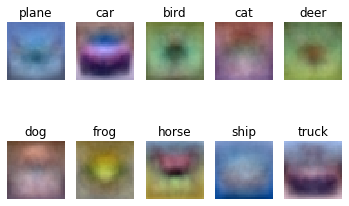

In [32]:
# Визуализируем веса после обучения для каждого класса.
w = best_softmax.W[:-1,:] # уберем отклонения
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])